---
title: " Applying Universal differential equation for discovering infectious disease model"
---
# Applying Universal differential equation for discovering infectious disease model

SciML software provides functionality to mix physical laws and machine learning model. This approach integrate the two long separated fields: physical modeling and machine learning, and leverage the strengths from both sides.

Specifically, the universal differential equation (UDE) is a unifying framework connecting physical modeling and data-driven approach, and SciML software provides state-of-art implementation and high-performance computing with Julia.

In this session, we are going to investigate an infectious disease model, SIR model, as a demonstration of applying UDE approach. This method can be divided by three parts:


**Part I: Data acquisition with ground truth model**

- Use DifferentialEquation.jl to implement SIR model
- Use ODE solver to get solution
- Apply noise

**Part II: Model Surrogation**

- Assume SIR model is partly known, and use convolution neural network (CNN) as universal approximator to surrogate the unknown process.
- The UDE model is a combination of ODE and CNN frameworks
- Use Automatic Differentiation to achieve gradient descent


**Part III: Model discovery**


## References
> This notebook is modified from 
> 1. https://github.com/epirecipes/sir-julia/blob/master/notebook/ude/ude.ipynb 
> 2. https://github.com/ChrisRackauckas/universal_differential_equations/blob/master/LotkaVolterra/scenario_1.jl
>
> The original UDE paper: Rackauckas, Christopher, et al. "Universal differential equations for scientific machine learning." arXiv preprint arXiv:2001.04385 (2020).


## Activate Environment

In [1]:
using Pkg
Pkg.activate("ude")
Pkg.instantiate()

  Activating project at `~/work/Julia-for-SciML/Julia-for-SciML/hands-on/ude`
    Updating registry at `~/.julia/registries/General.toml`
   Installed ShowCases ──────────────────────── v0.1.0
   Installed ContextVariablesX ──────────────── v0.1.3
   Installed Enzyme_jll ─────────────────────── v0.0.43+0
   Installed Accessors ──────────────────────── v0.1.20
   Installed ConsoleProgressMonitor ─────────── v0.1.2
   Installed NNlib ──────────────────────────── v0.8.9
   Installed LuxLib ─────────────────────────── v0.1.6
   Installed SciMLSensitivity ───────────────── v7.10.2
   Installed PDMats ─────────────────────────── v0.11.16
   Installed Contour ────────────────────────── v0.6.2
   Installed TimerOutputs ───────────────────── v0.5.21
   Installed NNlibCUDA ──────────────────────── v0.2.4
   Installed Measures ───────────────────────── v0.3.1
   Installed ProgressMeter ──────────────────── v1.7.2
   Installed LabelledArrays ─────────────────── v1.12.4
   Installed StaticArrays ──

## Libraries

In [2]:
using OrdinaryDiffEq
using Distributions
using DataDrivenDiffEq
using ModelingToolkit
using DiffEqFlux, Lux
using Optimization
using OptimizationPolyalgorithms
using Random
using ComponentArrays
using Statistics
using Plots;

┌ Info: Precompiling OrdinaryDiffEq [1dea7af3-3e70-54e6-95c3-0bf5283fa5ed]
└ @ Base loading.jl:1664
┌ Warning: Replacing docs for `SciMLBase.sol :: Union{Tuple, Tuple{D}, Tuple{S}, Tuple{N}, Tuple{T}} where {T, N, S, D}` in module `SciMLBase`
└ @ Base.Docs docs/Docs.jl:240
┌ Info: Precompiling DataDrivenDiffEq [2445eb08-9709-466a-b3fc-47e12bd697a2]
└ @ Base loading.jl:1664
┌ Warning: The variable syntax (u[1:n])(t) is deprecated. Use (u(t))[1:n] instead.
│                   The former creates an array of functions, while the latter creates an array valued function.
│                   The deprecated syntax will cause an error in the next major release of Symbolics.
│                   This change will facilitate better implementation of various features of Symbolics.
└ @ Symbolics ~/.julia/packages/Symbolics/FGTCH/src/variable.jl:129
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages

In [3]:
# Random seeds
rng = Random.default_rng()
Random.seed!(123);

## SIR model for spread of disease

\begin{align}
    \frac{dS}{dt} &= -\beta S(t)I(t)\\ 
    \frac{dI}{dt} &= \beta S(t)I(t)-\gamma I(t)\\
    \frac{dR}{dt} &= \beta S(t)I(t)
\end{align}

- $S$: Susceptible individuals
- $I$: Infected individauls
- $R$: Recovered individuals
- $\beta$: Infectious rate
- $\gamma$: Recovery rate

In [4]:
function sir_ode(u,p,t)
    (S,I,R) = u
    (β,γ) = p
    dS = -β*S*I
    dI = β*S*I - γ*I
    dR = β*S*I
    [dS,dI,dR]
end;

## ODE solver
- more solvers can be found at https://diffeq.sciml.ai/stable/solvers/ode_solve/

In [5]:
solver = RadauIIA3(); # Fully-Implicit Runge-Kutta Methods

In [6]:
N = 1000.0
p = [0.5,0.25]
u0 = [0.99, 0.01, 0.0]
tspan = (0., 40.)
δt = 1;

In [7]:
sir_prob = ODEProblem(sir_ode, u0, tspan, p)
sir_sol = solve(sir_prob, solver, saveat = δt);

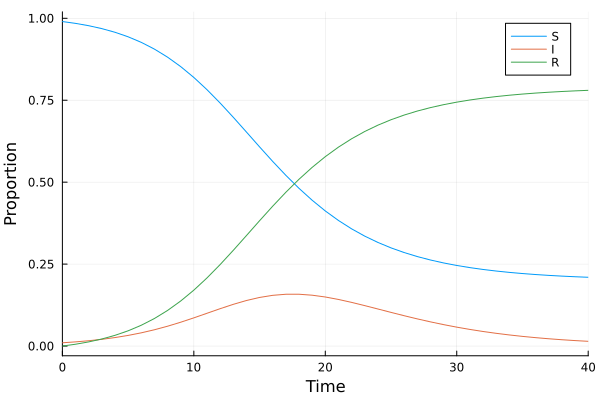

In [8]:
plot(sir_sol,
     xlabel = "Time",
     ylabel = "Proportion",
     labels = ["S" "I" "R"])

## Generating the measurement
- The time series data is processed with Poisson noise

In [9]:
train_time = 30.0
tsdata = Array(sir_sol(0:δt:train_time))
cdata = diff(tsdata[3,:])
noisy_data = rand.(Poisson.(N .* cdata));

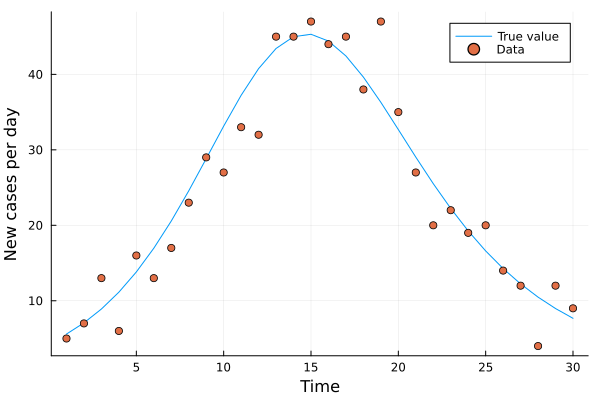

In [10]:
plot(1:δt:train_time, N .* cdata,
     xlabel = "Time",
     ylabel = "New cases per day",
     label = "True value")
scatter!(1:δt:train_time, noisy_data, label="Data")

## Create neural network to approximate unknown mechanism

\begin{align}
    \frac{dS}{dt} &= -\lambda_{NN}(I(t), \beta, \gamma) S(t)\\
    \frac{dI}{dt} &= \lambda_{NN}(I(t), \beta, \gamma) S(t)-\gamma I(t)\\
    \frac{dR}{dt} &= \lambda_{NN}(I(t), \beta, \gamma)S(t)
\end{align}

In [11]:
foi1 = Lux.Dense(1, 1, relu, bias=false)
p1_, st1 = Lux.setup(rng, foi1)
p1_, length(p1_)

((weight = Float32[1.5860611;;],), 1)

Build universal differential equation with partly known SIR mechanism

In [12]:
function sir_ude(u,p_,t,foi, st)
    S,I,R = u
    (β,γ) = p
    λ= foi([I], p_, st)[1][1]
    dS = -λ*S
    dI = λ*S - γ*I
    dR = λ*S
    [dS, dI, dR]
end;

In [13]:
tspan_train = (0,train_time)
sir_ude1 = (u,p_,t) -> sir_ude(u,p_,t,foi1, st1)
prob_ude1 = ODEProblem(sir_ude1,
                      u0,
                      tspan_train,
                      p1_);

To fit this model, we first need to define a function that predicts the outcome given a set of parameters.

In [14]:
function predict(θ, prob)
    Array(solve(prob,
                solver;
                u0 = u0,
                p = θ,
                saveat = δt,
                sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP())))
end;

Secondly, we define a loss function that uses this predict function to calculate the loss between the predicted data and the true data. We employ a Poisson loss, as we are comparing our model against counts of new cases.

In [15]:
function loss(θ, prob)
    pred = predict(θ, prob)
    cpred = abs.(N*diff(pred[3,:]))
    Flux.poisson_loss(cpred, float.(noisy_data)), cpred
end;

We run this function once to make sure it is precompiled.

In [16]:
loss(prob_ude1.p, prob_ude1);

To keep track of the running of the model, we store the losses in a `Vector` and use a callback to report on the model fit every 10 epochs.

In [17]:
const losses1 = []
callback1 = function (p, l, pred)
    push!(losses1, l)
    numloss = length(losses1)
    if numloss % 10 == 0
        display("Epoch: " * string(numloss) * " Loss: " * string(l))
    end
    return false
end;

In [18]:
adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x,p)->loss(x, prob_ude1), adtype)
optprob = Optimization.OptimizationProblem(optf, ComponentVector{Float64}(p1_))
res_ude1 = Optimization.solve(optprob, OptimizationPolyalgorithms.PolyOpt(), callback=callback1)

"Epoch: 10 Loss: 46.39434672449931"

"Epoch: 20 Loss: 36.43205698116247"

"Epoch: 30 Loss: 26.050977198450088"

"Epoch: 40 Loss: 15.1147435786317"

"Epoch: 50 Loss: 3.4525807760450156"

"Epoch: 60 Loss: -8.986147239707094"

"Epoch: 70 Loss: -22.13517826632064"

"Epoch: 80 Loss: -35.433924067674646"

"Epoch: 90 Loss: -47.26003122774066"

"Epoch: 100 Loss: -54.696354309716725"

"Epoch: 110 Loss: -56.649457760548415"

"Epoch: 120 Loss: -56.45193764109679"

"Epoch: 130 Loss: -56.50212229243084"

"Epoch: 140 Loss: -56.63738420283777"

"Epoch: 150 Loss: -56.65655302983397"

"Epoch: 160 Loss: -56.651828718741164"

"Epoch: 170 Loss: -56.65572714380096"

"Epoch: 180 Loss: -56.657674602165706"

"Epoch: 190 Loss: -56.65750509690865"

"Epoch: 200 Loss: -56.6575848256935"

"Epoch: 210 Loss: -56.657684365239035"

"Epoch: 220 Loss: -56.65768056000613"

"Epoch: 230 Loss: -56.65768264189016"

"Epoch: 240 Loss: -56.65768700304572"

"Epoch: 250 Loss: -56.657686751174005"

"Epoch: 260 Loss: -56.65768689313222"

"Epoch: 270 Loss: -56.6576870966963"

"Epoch: 280 Loss: -56.657687086404614"

"Epoch: 290 Loss: -56.65768709618854"

"Epoch: 300 Loss: -56.65768709852671"

u: ComponentVector{Float64}(weight = [0.4936023446329203;;])

The fitted parameter in this model corresponds to the infectivity parameter, `β`.

In [19]:
res_ude1.minimizer, losses1[end]

((weight = [0.4936023446329203;;]), -56.65768709902596)

This model is fast to converge to an optimum due to the small number of trainable parameters.

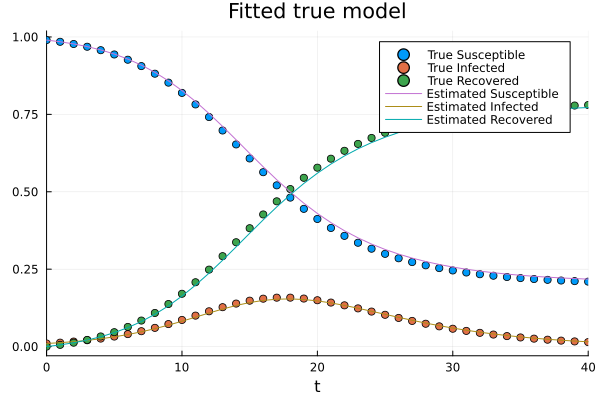

In [20]:
prob_ude1_fit = ODEProblem(sir_ude1, u0, tspan, res_ude1.minimizer)
sol_ude1_fit = solve(prob_ude1_fit, solver, saveat = δt)
scatter(sir_sol, label=["True Susceptible" "True Infected" "True Recovered"],title="Fitted true model")
plot!(sol_ude1_fit, label=["Estimated Susceptible" "Estimated Infected" "Estimated Recovered"])

This plots the relationship between `i` and the force of infection, `λ`, which shows a good match.

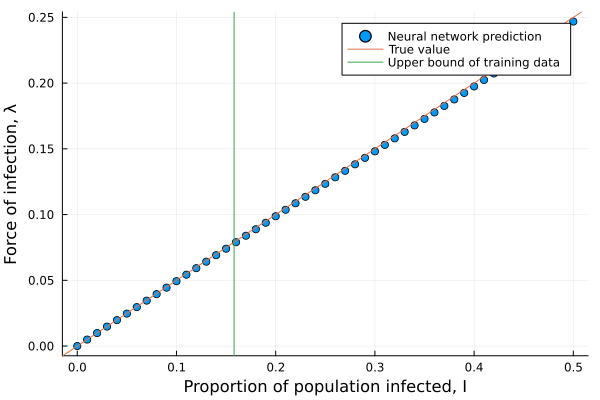

In [21]:
Imax = maximum(tsdata[2,:])
Igrid = 0:0.01:0.5
λ = [foi1([I],res_ude1.minimizer, st1)[1][1] for I in Igrid]
scatter(Igrid,λ,xlabel="Proportion of population infected, I",ylab="Force of infection, λ",label="Neural network prediction")
Plots.abline!(p[1],0,label="True value")
Plots.vline!([Imax],label="Upper bound of training data")

## Multiple layer network

In the absence of prior knowledge, we use a neural network with multiple layers.

In [22]:
Random.seed!(1234)
nhidden = 4
foi2 = Lux.Chain(Lux.Dense(1, nhidden, relu, init_weight= Lux.glorot_uniform),
                     Lux.Dense(nhidden, nhidden, relu),
                     Lux.Dense(nhidden, 1, relu))
p2_, st2 = Lux.setup(rng, foi2)

((layer_1 = (weight = Float32[0.49557778; -0.38126603; -0.42284605; 0.107465595;;], bias = Float32[0.0; 0.0; 0.0; 0.0;;]), layer_2 = (weight = Float32[-0.15969938 -0.25347877 0.49135512 0.78781974; 0.8177637 0.035255868 0.58824235 -0.5106646; -0.6919587 -0.16589832 -0.77170587 0.78050417; -0.8402026 0.24172777 0.809115 0.047083568], bias = Float32[0.0; 0.0; 0.0; 0.0;;]), layer_3 = (weight = Float32[0.20837806 0.16283458 -0.48723406 0.38921136], bias = Float32[0.0;;])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

We wrap this neural network in a new `ODEProblem`.

In [23]:
sir_ude2 = (u,p_,t) -> sir_ude(u,p_,t,foi2, st2)
prob_ude2 = ODEProblem(sir_ude2,
                      u0,
                      tspan_train,
                      p2_);

We define a new data structure to store the losses from the fitting of this more complex model.

In [24]:
const losses2 = []
callback2 = function (p, l, pred)
    push!(losses2, l)
    numloss = length(losses2)
    if numloss % 10 == 0
        display("Epoch: " * string(numloss) * " Loss: " * string(l))
    end
    return false
end;

In [25]:
optf2 = Optimization.OptimizationFunction((x,p)->loss(x, prob_ude2), adtype)
optprob2 = Optimization.OptimizationProblem(optf2, ComponentVector{Float64}(p2_))
res_ude2 = Optimization.solve(optprob2, OptimizationPolyalgorithms.PolyOpt(), callback=callback2)

"Epoch: 10 Loss: -46.799260374683094"

"Epoch: 20 Loss: -51.42200189136061"

"Epoch: 30 Loss: -52.332849893113384"

"Epoch: 40 Loss: -52.68171188910899"

"Epoch: 50 Loss: -53.46893725501623"

"Epoch: 60 Loss: -54.76561455453879"

"Epoch: 70 Loss: -56.45966833738093"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative

"Epoch: 80 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative

"Epoch: 90 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative

"Epoch: 100 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative

"Epoch: 110 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative

"Epoch: 120 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative

"Epoch: 130 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative

"Epoch: 140 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative

"Epoch: 150 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative

"Epoch: 160 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative

"Epoch: 170 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative

"Epoch: 180 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative

"Epoch: 190 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative

"Epoch: 200 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative

"Epoch: 210 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative

"Epoch: 220 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative

"Epoch: 230 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative

"Epoch: 240 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative

"Epoch: 250 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative

"Epoch: 260 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative

"Epoch: 270 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative

"Epoch: 280 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative

"Epoch: 290 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative

"Epoch: 300 Loss: Inf"

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /home/runner/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /home/runner/.julia/packages/SciMLBase/pmQ12/src/integrator_interface.jl:496


"Epoch: 310 Loss: -56.66513928902359"

"Epoch: 320 Loss: -56.665139299016126"

"Epoch: 330 Loss: -56.66513925188227"

"Epoch: 340 Loss: -56.665139270470185"

"Epoch: 350 Loss: -56.66513919119394"

u: ComponentVector{Float64}(layer_1 = (weight = [0.6991825034899273; -0.3812660276889801; -0.4228460490703583; -0.027002031753358028;;], bias = [0.05949680699948741; 0.0; 0.0; 0.0604376404258787;;]), layer_2 = (weight = [-0.10428838818111084 -0.2534787654876709 0.49135512113571167 0.7944243135622098; 0.8983487508963544 0.03525586798787117 0.5882423520088196 -0.4997345690021149; -0.7385705921782102 -0.16589832305908203 -0.7717058658599854 0.8559028261867959; -0.8402026295661926 0.2417277693748474 0.8091149926185608 0.04708356782793999], bias = [0.05984992266868655; 0.0598572270465148; 0.12671034415020374; 0.0;;]), layer_3 = (weight = [0.09030660249001296 0.24263990063692892 -0.6599809301971058 0.38921135663986206], bias = [0.05912218020974564;;]))

Overall, the 'true' model and the more flexible model give a comparable fit to the data in terms of the loss function.

In [26]:
losses1[end],losses2[end]

(-56.65768709902596, -56.66513919119378)

Consistent with this, the multilayer model gives a good fit when plotted alongside the data.

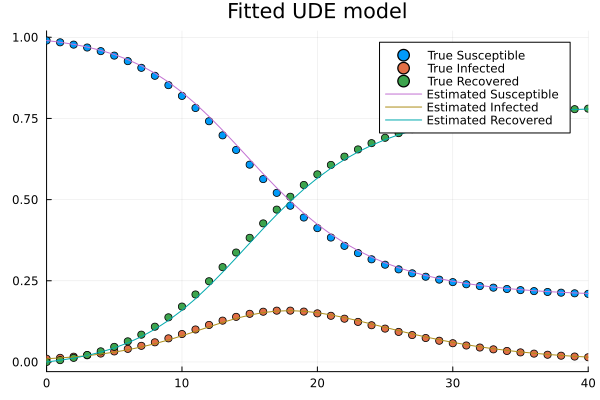

In [27]:
prob_ude2_fit = ODEProblem(sir_ude2, u0, tspan, res_ude2.minimizer)
sol_fit = solve(prob_ude2_fit, solver)
sol_ude2_fit = sol_fit(tspan[1]:δt:tspan[2])
scatter(sir_sol, label=["True Susceptible" "True Infected" "True Recovered"],title="Fitted UDE model", dpi=300)
plot!(sol_ude2_fit, label=["Estimated Susceptible" "Estimated Infected" "Estimated Recovered"])

This is the inferred functional relationship between the proportion of infected individuals and the force of infection.

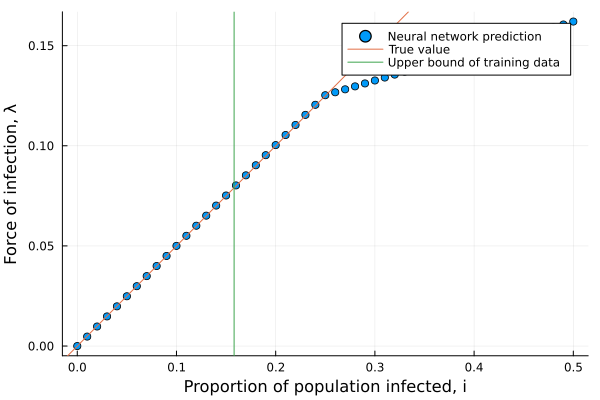

In [28]:
λs = [foi2([I],res_ude2.minimizer, st2)[1][1] for I in Igrid]
scatter(Igrid, λs, xlabel="Proportion of population infected, i", ylab="Force of infection, λ", label="Neural network prediction", dpi=300)
Plots.abline!(p[1], 0,label="True value")
Plots.vline!([Imax], label="Upper bound of training data")

## Symbolic Regression

In [29]:
t_measure = tspan[1]:δt:tspan[2]
X̂ = Is = reshape(collect(Iterators.flatten(sol_fit(t_measure, idxs=[2]).u)), 1, length(t_measure))

1×41 Matrix{Float64}:
 0.01  0.0124666  0.0155791  0.0194807  …  0.0201411  0.0174061  0.0150213

In [30]:
Ŷ = reshape([foi2([I],res_ude2.minimizer, st2)[1][1] for I in Is], 1, length(Is))

1×41 Matrix{Float64}:
 0.00473386  0.00597508  0.00754136  …  0.00983704  0.00846075  0.00726067

In [31]:
# Create a Basis
@variables u[1:1]
# Generate the basis functions, multivariate polynomials up to deg 5
# and sine
b = [polynomial_basis(u, 5); sin.(u); cos.(u); exp.(u)]
basis = Basis(b,u);

In [32]:
basis

Model ##Basis#396 with 9 equations
States (1):
  u[1]
Parameters (0):

In [33]:
λ = exp10.(-3:0.01:5)
# Create an optimizer for the SINDy problem
opt = STLSQ(λ)
# Define different problems for the recovery
nn_problem = DirectDataDrivenProblem(X̂, Ŷ)
# Test on ideal derivative data for unknown function ( not available )
nn_res = solve(nn_problem, basis, opt, maxiter = 10000, progress = true)

STLSQ   0%|▏                                             |  ETA: 0:11:40
  Threshold:          0.0010232929922807535
  Best Objective:     0.0
  Best Sparsity:      8.0
  Current Objective:  0.0
  Current Sparsity:   8.0

Linear Solution

In [34]:
result(nn_res)

Model ##Basis#400 with 1 equations
States (1):
  u[1]
Parameters (1):
  p₁

In [35]:
parameters(nn_res)

1-element Vector{Float64}:
 0.5

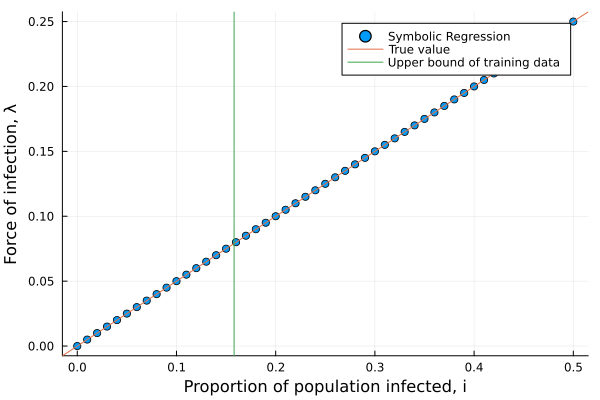

In [36]:
scatter(Igrid, [nn_res([I], parameters(nn_res))[1] for I in Igrid], xlabel="Proportion of population infected, i", ylab="Force of infection, λ", label="Symbolic Regression")
Plots.abline!(p[1], 0,label="True value")
Plots.vline!([Imax], label="Upper bound of training data")